# **Support Vector Machine (SVM)**

---

## **Introduction**
Support Vector Machine (SVM) is a supervised learning algorithm used for **classification and regression** tasks. It is particularly effective in high-dimensional spaces and works well when the number of dimensions exceeds the number of samples.

SVM aims to find the optimal **decision boundary** that maximizes the margin between different classes.

---

## **Methodology**

### **1. Problem Definition**
Given a dataset of $N$ samples where each sample $\mathbf{x}_j$ is a $d$-dimensional vector:

$$
\mathbf{x}_j = (x_{j1}, x_{j2}, \dots, x_{jd})
$$

Each sample belongs to one of two classes $y_j \in \{-1,1\}$. The goal of SVM is to find a hyperplane that best separates the two classes.

A **linear decision boundary** is given by:

$$
f(\mathbf{x}) = \mathbf{w}^T\mathbf{x} + b = 0
$$

where:
- $\mathbf{w}$ is the weight vector.
- $b$ is the bias term.

### **2. Maximum Margin Principle**
SVM finds the hyperplane that maximizes the **margin**, defined as the distance between the hyperplane and the closest data points (support vectors).

For correctly classified points:

$$
y_j (\mathbf{w}^T\mathbf{x}_j + b) \geq 1, \quad \forall j
$$

The margin is:

$$
\frac{2}{\|\mathbf{w}\|}
$$

To maximize the margin, we solve the following optimization problem:

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2
$$

subject to:

$$
y_j (\mathbf{w}^T\mathbf{x}_j + b) \geq 1, \quad \forall j
$$

This is a **convex quadratic optimization** problem.

### **3. Soft-Margin SVM**
If data is not linearly separable, we introduce **slack variables** $\xi_j$ to allow misclassification:

$$
y_j (\mathbf{w}^T\mathbf{x}_j + b) \geq 1 - \xi_j, \quad \xi_j \geq 0
$$

The new objective function becomes:

$$
\min_{\mathbf{w}, b} \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{j=1}^{N} \xi_j
$$

where $C$ is a hyperparameter controlling the trade-off between maximizing the margin and minimizing classification errors.

### **4. Kernel Trick for Nonlinear SVM**
For nonlinear classification, we map data to a higher-dimensional space using a kernel function $K(\mathbf{x}_i, \mathbf{x}_j)$, such as:

- **Linear Kernel:**  
  $$
  K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^T \mathbf{x}_j
  $$
- **Polynomial Kernel:**  
  $$
  K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i^T \mathbf{x}_j + 1)^p
  $$
- **Radial Basis Function (RBF) Kernel:**  

  $$
  K(\mathbf{x}_i, \mathbf{x}_j) = \exp\left(-\gamma \|\mathbf{x}_i - \mathbf{x}_j\|^2\right)
  $$

where $\gamma$ controls the influence of each training sample.

### **5. Decision Rule**
Once trained, predictions are made using:

$$
\hat{y} = \text{sign}(\mathbf{w}^T \mathbf{x} + b)
$$

For nonlinear SVMs using kernels:

$$
\hat{y} = \text{sign}\left( \sum_{j=1}^{N} \alpha_j y_j K(\mathbf{x}_j, \mathbf{x}) + b \right)
$$

where $\alpha_j$ are the Lagrange multipliers obtained during training.

---

## **Prerequisites**
- `numpy`
- `scikit-learn`
- `matplotlib`

---

The following is an example of using SVM to analyze EEG data recorded in a driving simulation experiment. The goal is to classify **steering angles** based on EEG signals.

You can try applying SVM to other BCI datasets.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

from utils import (
    make_binary_label,
    make_multi_label,
    load_data_model,
)

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [ ]:
# load train and test data
data_dir = "../data/data_model/sub-jimingda/forward1.npz"
data_list = load_data_model(data_dir)
train_data, train_label, test_data, test_label = data_list["feature_train"], data_list["steering_train"], data_list["feature_test"], data_list["steering_test"]

# simply flatten the data from (sample, channel, timepoint) to (sample, channel*timepoint)
train_data = np.reshape(train_data, (train_data.shape[0], -1))
test_data = np.reshape(test_data, (test_data.shape[0], -1))

# make binary labels
train_label_2 = make_binary_label(train_label)
test_label_2 = make_binary_label(test_label)

# make multi labels
split_list = [-1, -0.1, 0.1, 1]
train_label_3 = make_multi_label(train_label, split_list)
test_label_3 = make_multi_label(test_label, split_list)

# nomalization
scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
test_data_scaled = scaler.transform(test_data)

In [3]:
# Observe the change in cumulative variance of data.
cumulative_variance_ratio = []
for i in range(21):
    n_components = 1 + i * 100
    pca = PCA(n_components=n_components)
    pca.fit(train_data_scaled)
    cumulative_variance_ratio.append(np.sum(pca.explained_variance_ratio_))

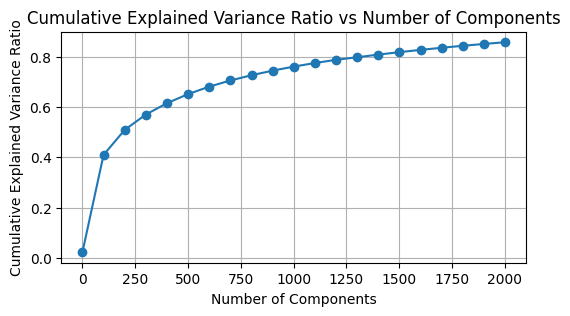

In [11]:
plt.figure(figsize=(6, 3))
x_label = [1 + i*100 for i in range(21)]
plt.plot(x_label, cumulative_variance_ratio, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio vs Number of Components')
plt.grid(True)
plt.show()

In [10]:
n_components = 2000
pca = PCA(n_components=n_components)
train_data_pca = pca.fit(train_data_scaled)
print("主成分的方差解释比例:", np.sum(pca.explained_variance_ratio_))

主成分的方差解释比例: 0.85792829839458


In [18]:
# Result shows that 2000 components can expland 85% variance of data, but this dimension is still too high for classical SVM
# To show the use of SVM, we forcibly reduce the dimension of the data, but this will lose most of the EEG information.
train_data, train_label, test_data, test_label = data_list["feature_train"], data_list["steering_train"], data_list["feature_test"], data_list["steering_test"]

train_data_reduced = train_data[:, :, 100]
test_data_reduced = test_data[:, :, 100]

train_data_reduced = scaler.fit_transform(train_data_reduced)
test_data_reduced = scaler.transform(test_data_reduced)

In [19]:
# SVM model for binary label classification
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42) 
model.fit(train_data_reduced, train_label_2)

pred_2 = model.predict(test_data_reduced)

accuracy_2 = accuracy_score(test_label_2, pred_2)
print(f"Accuracy: {accuracy_2 * 100:.2f}%")

Accuracy: 46.44%


In [20]:
# SVM model for multi label classification
model = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=42) 
model.fit(train_data_reduced, train_label_3)

pred_3 = model.predict(test_data_reduced)

accuracy_3 = accuracy_score(test_label_3, pred_3)
print(f"Accuracy: {accuracy_3 * 100:.2f}%")

Accuracy: 93.81%
